# PARTIE 3 : Amélioration du modèle de base

## Import librairies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Import des données

In [2]:
dataset = pd.read_csv('./src/dataset_for_ml.csv')
print(dataset.shape)
dataset.head()

(278449, 6)


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


Pour réduire les temps de calcul, nous travaillons avec un échantillon de 10 000 observations.

In [3]:
dataset = dataset.sample(10000)

## Preprocessings Sklearn

In [4]:
# Separate target variable y from features X:
target_variable = 'converted'
print('Separating labels from features...')
y = dataset.loc[:,target_variable]
X = dataset.drop(target_variable, axis = 1)
print('...Done')
print()
print('y:')
print(y.head())
print()
print('X:')
print(X.head())
print()

Separating labels from features...
...Done

y:
274501    0
76029     0
270493    0
115363    0
123157    0
Name: converted, dtype: int64

X:
        country  age  new_user source  total_pages_visited
274501    China   30         1    Ads                    3
76029        US   36         1    Seo                    6
270493       US   33         0    Seo                    3
115363  Germany   26         1    Seo                    7
123157       UK   44         1    Ads                    1



In [5]:
# Distinguish numeric and categorical features:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', 'source']

# Create pipeline for numeric features:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

# Use ColumnTransformer to male a preprocessor object that describe all the treatments to be done:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Application des preprocessings

In [6]:
# Preprocessings:
print('Performing preprocessings on train set...')
print(X.head())
X = preprocessor.fit_transform(X)
print('...Done')
print(X[0:5])
print()

Performing preprocessings on train set...
        country  age  new_user source  total_pages_visited
274501    China   30         1    Ads                    3
76029        US   36         1    Seo                    6
270493       US   33         0    Seo                    3
115363  Germany   26         1    Seo                    7
123157       UK   44         1    Ads                    1
...Done
[[-0.08744473 -0.57756798  0.          0.          0.          1.
   0.          0.        ]
 [ 0.653403    0.46913006  0.          0.          1.          1.
   0.          1.        ]
 [ 0.28297913 -0.57756798  0.          0.          1.          0.
   0.          1.        ]
 [-0.58134321  0.81802941  1.          0.          0.          1.
   0.          1.        ]
 [ 1.64119996 -1.27536668  0.          1.          0.          1.
   0.          0.        ]]



## Rééquilibrer le jeu de données avec SMOTE

SMOTE signifie Synthetic Minority Oversampling Technique. 

C'est une technique couramment utilisée pour résoudre les problèmes de déséquilibre de classe.

Afin de contourner le problème de notre jeu de données déséquilibré, nous utilisons cette approche pour augmenter le nombre d'observations de la classe minoritaire (converted = 1).



In [7]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [8]:
X_resample, y_resample = sm.fit_resample(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

## Modèle Random Forest

Nous entraînons un modèle ensembliste Random forest. 

Selon la documentation, les modèles ensemblistent seraient les mieux adaptés pour les problèmes de classification avec des jeux de données déséquilibrés.

## Recherche des meilleurs hyperparamètres

In [21]:
from sklearn.model_selection import GridSearchCV
print("Grid search...")
classifier = RandomForestClassifier()

params = {
    'max_depth': [5,10,15],
    'min_samples_split': [20,30],
    'min_samples_leaf': [2,4,6],
    'n_estimators': [100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3, verbose = 1)

Grid search...


In [22]:
gridsearch.fit(X_train, y_train)
print("...Done.")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


...Done.


In [23]:
# Print best hyperparameters:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

# Print R2 scores:
print("R2 score on train set : ", gridsearch.score(X_train, y_train))
print("R2 score on test set : ", gridsearch.score(X_test, y_test))

Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
Best validation accuracy :  0.9853699641649104
R2 score on training set :  0.9931302080020354
R2 score on test set :  0.9867718137878403


## Résultats et performance

In [24]:
# Print classification report:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1957
           1       0.98      0.99      0.99      1974

    accuracy                           0.99      3931
   macro avg       0.99      0.99      0.99      3931
weighted avg       0.99      0.99      0.99      3931



### Rapport de classification : 

- Nous obtenons de très bon scores sur la classe 0 mais aussi sur classe 1 : 0.98 pour la précision et 0.99 pour le recall.

- **Précision** : sur tous les utilisateurs dont le modèle prévoyait qu'ils s'abonneraient à la newsletter, 98 % l'ont effectivement fait.

- **Recall**: sur tous les utilisateurs réellement abonnés à la newsletter, le modèle a prédit correctement ce résultat pour 99 % de ces utilisateurs.

- **F1 score** : il résulte un F1 score de 0.99.

## Matrices de confusion

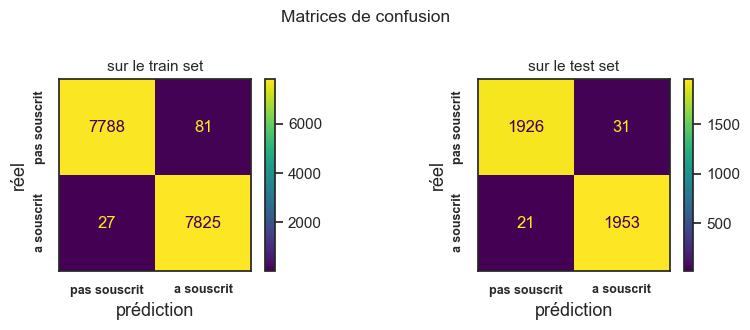

In [25]:
sns.set(rc={'figure.figsize':(9, 3)}, style='white')
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.125, wspace=0.5)

ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax = axes[0])
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax = axes[1])

fig.suptitle('Matrices de confusion', fontsize=12.5)
fig.subplots_adjust(top=.75)

axes[0].set_title('sur le train set', fontsize=11)
axes[1].set_title('sur le test set', fontsize=11)

axes[0].set_xlabel('prédiction', fontsize=13)
axes[1].set_xlabel('prédiction', fontsize=13)
axes[0].set_ylabel('réel', fontsize=13)
axes[1].set_ylabel('réel', fontsize=13)

axes[0].set_xticks([0,1], ['pas souscrit', 'a souscrit'], fontsize=9, fontweight='bold')
axes[1].set_xticks([0,1], ['pas souscrit', 'a souscrit'], fontsize=9, fontweight='bold')
axes[0].set_yticks([0,1], ['pas souscrit', 'a souscrit'], fontsize=9, rotation=90, va='center', fontweight='bold')
axes[1].set_yticks([0,1], ['pas souscrit', 'a souscrit'], fontsize=9, rotation=90, va='center', fontweight='bold')

plt.show()

### Résultats :

Les matrices de confusion confirment les résultats du rapport de classification :

- Elles montrent que le modèle amélioré est efficace pour prédire la classe 0 mais aussi pour prédire la classe 1.

- Grâce au suréchantillonnage du jeu de données avec la technique SMOTE et l'utilisation d'un modèle ensembliste Random Forest, nous obtenons un modèle qui donne de bonnes prédictions.

## Importance des features

Nous examinons comment le modèle amélioré pondère les features pour faire ses prédictions.

In [26]:
# Get the names and coefficients of the features:
feature_names_out = preprocessor.get_feature_names_out()
feature_names = [fname for fname in feature_names_out]
coefs = pd.DataFrame(index = feature_names, data = gridsearch.best_estimator_.feature_importances_.transpose(), columns=["coefficients"])

In [27]:
feature_importance = coefs.sort_values(by='coefficients', ascending=False)
feature_importance

,coefficients
num__total_pages_visited,0.672020
cat__new_user_1,0.129433
num__age,0.098062
cat__country_UK,0.028363
cat__country_US,0.025138
cat__source_Seo,0.023893
cat__country_Germany,0.012388
cat__source_Direct,0.010704


In [28]:
feature_importance = feature_importance.transpose()

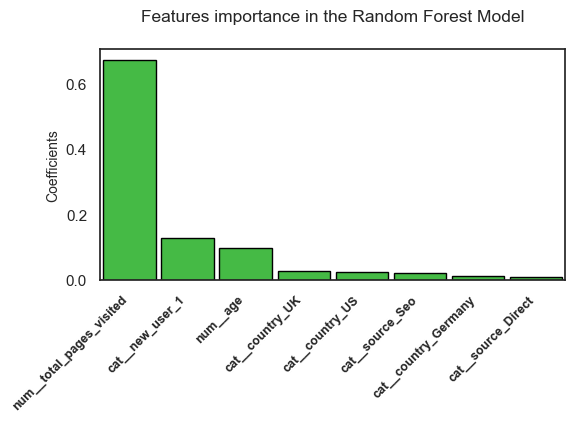

In [29]:
# Plot coefficients:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.set(rc={'figure.figsize':(6, 3)}, style='white')
sns.barplot(data = feature_importance, orient = 'v', palette = ['limegreen'], width = .9, edgecolor = 'black')
plt.title('Features importance in the Random Forest Model', fontsize=12.5, pad=20)
plt.xlabel('', fontsize=10)
plt.ylabel('Coefficients', fontsize=10)
plt.xticks(fontsize=9, fontweight='bold', rotation=45, ha='right')
plt.xticks(feature_importance.columns, fontsize=9, fontweight='bold', rotation=45, ha="right")
plt.legend('', frameon=False)
plt.show()

### Résultats : 

- La variable *total_pages_visited* est celle qui a le plus de poids dans le modèle amélioré, elle est largement devant les autres variables.

- Viennent ensuite les variables *new_user* et *age*. On remarque qu'elles avaient un poids négatif dans le modèle de base, elles présentent désormais un poids positif.

- Les pays ont désormais une moindre importance dans le modèle amélioré avec des coefficients presque nuls.

In [38]:
feature_importance.to_csv('./src/feature_importance.csv', index=False)

---

# The conversion rate challenge

Nous utilisons le template fourni pour générer les prédictions sur le jeu de données sans label.

Les prédictions sont enregistrées dans le dossier : */src/predictions_with_best_classifier.csv*

In [30]:
# Concatenate the train and test set to train the best classifier on all data with labels:
X = np.append(X_train,X_test,axis=0)
Y = np.append(y_train,y_test)
gridsearch.fit(X,Y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [20, 30], 'n_estimators': [100]},
             verbose=1)

In [32]:
# Read the dataset without label:
data_without_labels = pd.read_csv('./src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [33]:
features_list = ['age', 'total_pages_visited', 'country', 'new_user', 'source']
X_without_labels = data_without_labels.loc[:, features_list]

In [34]:
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.33439397  3.95812355  0.          1.          0.          0.
   0.          1.        ]
 [-1.07524169  0.12023072  0.          1.          0.          1.
   1.          0.        ]
 [ 0.15950451 -1.27536668  0.          0.          0.          1.
   0.          1.        ]
 [ 0.15950451  0.46913006  0.          0.          1.          1.
   0.          0.        ]
 [-0.70481783 -0.57756798  0.          0.          0.          0.
   0.          1.        ]]


In [35]:
# Make predictions and dump to file:
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('./src/predictions_with_best_classifier.csv', index=False)